<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Datesets" data-toc-modified-id="Datesets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Datesets</a></span></li><li><span><a href="#Create-windows" data-toc-modified-id="Create-windows-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create windows</a></span></li><li><span><a href="#Normalize-Data" data-toc-modified-id="Normalize-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Normalize Data</a></span></li><li><span><a href="#Split-train-and-test-data" data-toc-modified-id="Split-train-and-test-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Split train and test data</a></span></li><li><span><a href="#Build-Model" data-toc-modified-id="Build-Model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Build Model</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Prediction</a></span></li><li><span><a href="#Function-Test" data-toc-modified-id="Function-Test-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Function Test</a></span></li><li><span><a href="#Ref" data-toc-modified-id="Ref-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Ref</a></span></li></ul></div>

🦄 LSTM 주가 예측 모델

In [5]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import datetime
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense, Activation

# Datesets

In [6]:
data = fdr.DataReader('goog', '2010')
data

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2014-03-28,558.46,559.66,564.88,557.14,41120.0,0.0027
2014-03-31,555.45,565.34,565.45,555.41,10800.0,-0.0054
2014-04-01,565.61,557.18,566.89,557.18,7950.0,0.0183
2014-04-02,565.45,598.35,603.17,560.65,147100.0,-0.0003
2014-04-03,568.18,568.29,585.67,562.59,5100000.0,0.0048
...,...,...,...,...,...,...
2021-12-15,2947.37,2887.32,2950.34,2854.11,1350000.0,0.0165
2021-12-16,2896.77,2961.54,2971.03,2881.85,1370000.0,-0.0172
2021-12-17,2856.06,2854.29,2889.20,2835.76,2170000.0,-0.0141


In [7]:
data.dropna(inplace=True)
close = data.Close
close

Date
2014-03-28     558.46
2014-03-31     555.45
2014-04-01     565.61
2014-04-02     565.45
2014-04-03     568.18
               ...   
2021-12-15    2947.37
2021-12-16    2896.77
2021-12-17    2856.06
2021-12-20    2848.03
2021-12-21    2884.29
Name: Close, Length: 1950, dtype: float64

# Create windows

In [8]:
seq_len = 1 + 50

tmp = []
for i in range(len(close) - seq_len):
    tmp.append(close[i:i+seq_len])
    
len(tmp)
len(tmp[-1])

1899

51

# Normalize Data

In [9]:
normalized_close = []
for t in tmp:
    normalized_close.append( [ (x/t[0] - 1) for x in t] )
normalized_close = np.array(normalized_close)

len(normalized_close)
len(normalized_close[-1])
normalized_close[-1]

1899

51

array([ 0.        , -0.00862869, -0.02386902, -0.01539384,  0.00968184,
        0.01155966,  0.02073813,  0.02688924,  0.01684326,  0.01945293,
       -0.01021734, -0.00916062, -0.00274176,  0.04549252,  0.04336123,
        0.05865154,  0.02654652,  0.04146199,  0.04808077,  0.06159679,
        0.06558091,  0.06636988,  0.06563446,  0.04690981,  0.04778089,
        0.06846904,  0.06663049,  0.06440281,  0.06430285,  0.07606243,
        0.07066102,  0.05014066,  0.04784515,  0.04756312,  0.019635  ,
        0.04325413,  0.01710744,  0.01115268,  0.02656437,  0.01759653,
        0.02670717,  0.05698078,  0.06186454,  0.05747701,  0.06153967,
        0.0474703 ,  0.03508954,  0.05221126,  0.03414706,  0.01961358,
        0.01674687])

# Split train and test data

In [10]:
i = int(normalized_close.shape[0] * 0.9)
train = normalized_close[:i]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = train[:,-1]

x_test = normalized_close[i:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = normalized_close[i:,-1]

x_train.shape, x_test.shape

((1709, 50, 1), (190, 50, 1))

# Build Model

In [7]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(50,1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


# Training

In [8]:
model.fit(x_train, y_train,
         validation_data = (x_test, y_test),
         batch_size=10,
         epochs=20)

model.save('my_model.h5')

Epoch 1/20
171/171 [==============================] - 24s 93ms/step - loss: 0.0012 - val_loss: 5.5220e-04
Epoch 2/20
171/171 [==============================] - 14s 81ms/step - loss: 6.2377e-04 - val_loss: 8.7862e-04
Epoch 3/20
171/171 [==============================] - 12s 68ms/step - loss: 4.4642e-04 - val_loss: 2.6480e-04
Epoch 4/20
171/171 [==============================] - 13s 79ms/step - loss: 3.7229e-04 - val_loss: 3.2563e-04
Epoch 5/20
171/171 [==============================] - 10s 57ms/step - loss: 3.5550e-04 - val_loss: 2.0791e-04
Epoch 6/20
171/171 [==============================] - 9s 55ms/step - loss: 3.4694e-04 - val_loss: 2.1134e-04
Epoch 7/20
171/171 [==============================] - 9s 54ms/step - loss: 3.3635e-04 - val_loss: 2.1321e-04
Epoch 8/20
171/171 [==============================] - 9s 55ms/step - loss: 3.4484e-04 - val_loss: 2.3642e-04
Epoch 9/20
171/171 [==============================] - 10s 57ms/step - loss: 3.3632e-04 - val_loss: 2.0191e-04
Epoch 10/20
171/1

# Prediction

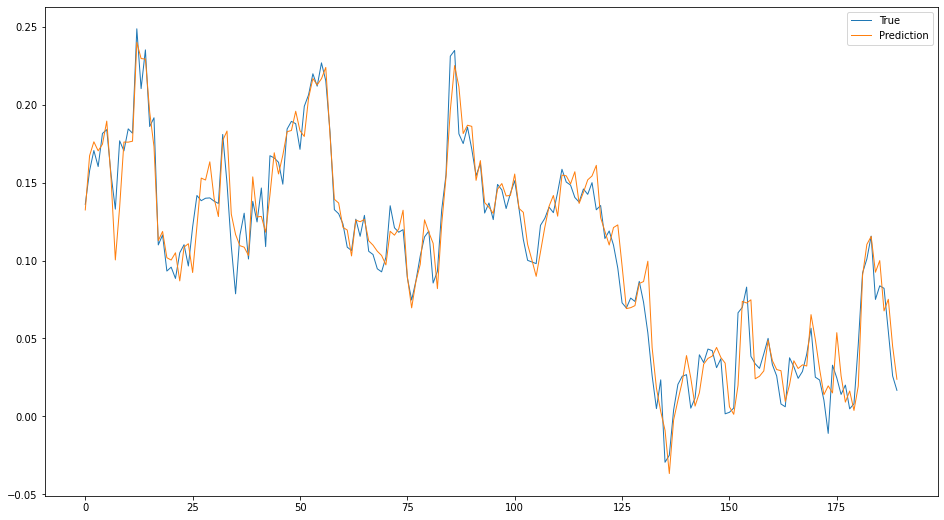

In [13]:
model = load_model('my_model.h5')
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(16, 9))
plt.rcParams['lines.linewidth'] = 1
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

# Function Test

In [47]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import datetime
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense, Activation


def lstm_prediction(data, my_model='./resources/my_model.h5', win=50):
    win += 1

    tmp = []
    for i in range(len(data) - win):
        tmp.append(data[i:i+win])

    normalized_data = []
    for t in tmp:
        normalized_data.append( [ (x/t[0] - 1) for x in t] )
    normalized_data = np.array(normalized_data)
    
    test = normalized_data[:, :-1]
    test = np.reshape(test, (test.shape[0], test.shape[1], 1))
    label = normalized_data[:, -1]
    
    model = load_model(my_model)
    pred = model.predict(test)

    fig = plt.figure(facecolor='white', figsize=(16, 9))
    plt.rcParams['lines.linewidth'] = 1
    ax = fig.add_subplot(111)
    ax.plot(label, label='True')
    ax.plot(pred, label='Prediction')
    ax.legend()
    plt.show()

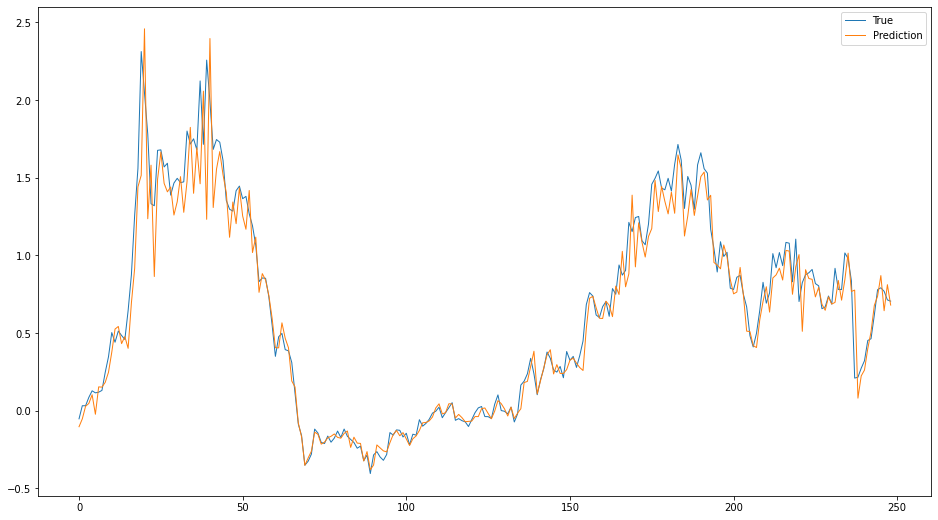

In [48]:
NVX_data = fdr.DataReader('NVX')
NVX_data.dropna(inplace=True)
NVX_close = NVX_data.Close[-300:]

lstm_prediction(NVX_close)

<AxesSubplot:xlabel='Date'>

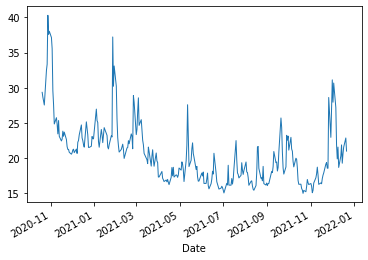

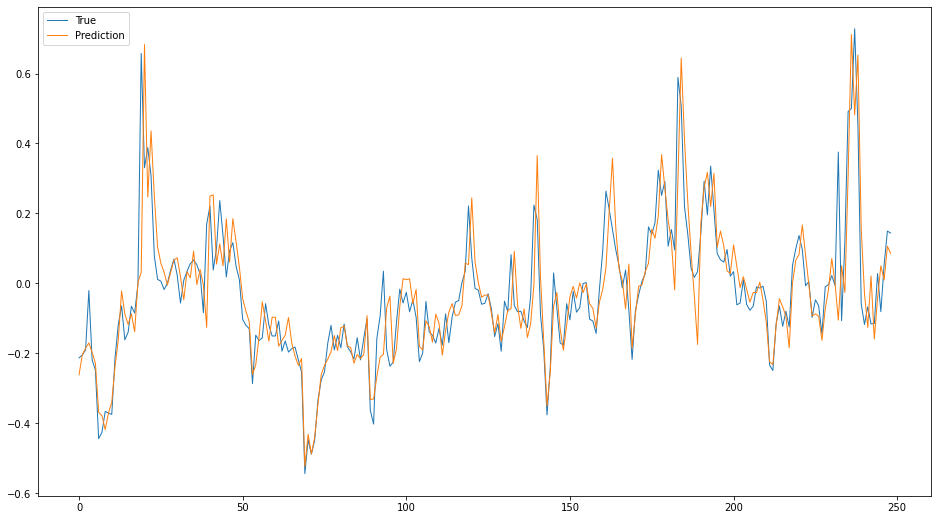

In [49]:
VIX_data = fdr.DataReader('VIX')
VIX_data.dropna(inplace=True)
VIX_close = VIX_data.Close[-300:]

VIX_close.plot()
lstm_prediction(VIX_close)

# Ref
빵형의 개발도상국 유튜브 - https://www.youtube.com/watch?v=sG_WeGbZ9A4